In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./digit_data.csv")

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.iloc[1, 1:]

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 1, Length: 784, dtype: int64

In [5]:
np.array(data.iloc[1, 1:]).reshape((28,28))

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18,  30, 137,
        137, 192,  86,  72,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  13,  86, 250, 254, 254,
        254, 254, 217, 246, 151,  32,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

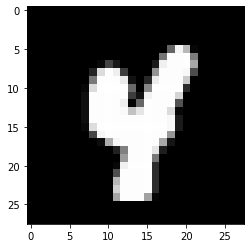

In [6]:
plt.imshow(np.array(data.iloc[int(np.random.random() * data.shape[0]), 1:]).reshape((28,28)), cmap="gray")

In [7]:
data = np.array(data)
m, n = data.shape

In [8]:
m,n

(42000, 785)

In [9]:
np.random.shuffle(data)

In [10]:
data_test = data[:1000].T
test_y = data_test[0]
test_x = data_test[1:n]

In [11]:
data_train = data[1000:].T
train_y = data_train[0]
train_x = data_train[1:n]

In [13]:
np.random.seed(0)

In [22]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):

        # self.weights = np.random.randn(n_inputs, n_neurons)
        self.weights = np.random.random((n_inputs, n_neurons)) - 0.5

        # self.biases = np.zeros(1, n_neurons)
        self.biases = np.random.random((1, n_neurons)) - 0.5

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights)  + self.biases

In [36]:
layer1 = Layer_Dense(784, 5)
layer2 = Layer_Dense(5, 2)

In [37]:
train_x[:,0].shape

(784,)

In [38]:
layer1.forward(train_x[:,0])

In [39]:
layer1.output

array([[ 676.17597845, 1274.29829791,  195.90631929,  909.20580896,
         104.56459891]])

In [40]:
layer2.forward(layer1.output)

In [41]:
layer2.output

array([[-730.22938867,  105.88892344]])